In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import sklearn.preprocessing
import sklearn.model_selection

In [6]:
import uproot
uproot.default_library = "np"

In [7]:
import os.path

In [8]:
import logging
logging.basicConfig(level=logging.INFO)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data

In [10]:
raw_names = [
    "data/sim09g_KJpsi_2017MD_folded.root:DecayTree;1",
    "data/sim09g_KJpsi_mumu2017MD.root:B2XMuMu_Line_Tuple/DecayTree;266",
    "data/sim09g_Kee_2017MD_folded.root:DecayTree;1",
    "data/sim09g_Kmumu_2017MD.root:B2XMuMu_Line_Tuple/DecayTree;2",
    
    "DLA/KPsi2See_2018_MD_folded.root:DecayTree;1",
    "DLA/KPsi2S_mumu_2018MD_folded.root:DecayTree;1",
#    "DLA/sim09h_Dplus_PhiPi_2018_MD_folded.root:DecayTree;1",
#    "DLA/sim09h_Dplus_PhiPi_mumu_2018_MD_folded.root:DecayTree;1",
]

In [11]:
raw_files = [uproot.open(os.path.join(os.path.expanduser("~/2021/"), name)) for name in raw_names]

### Truthing

In [12]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])

In [13]:
features = [
    "e_minus_TRUEPT",
    "e_plus_TRUEPT",
    "q",
]

In [14]:
aliases = {"q": "J_psi_1S_M", "q2": "J_psi_1S_M**2*1e-6"}

In [15]:
raw_all = [f.arrays(features, aliases=aliases, library="np") for f in raw_files]

In [16]:
# https://arxiv.org/abs/2103.11769
q_Kll_selector = join_and("q2 > 1.1", "q2 < 6.0")
#
q_Jpsi_e_selector = join_and("q2 > 6.0", "q2 < 12.96")
q_Jpsi_mu_selector = join_and("q2 > 8.68", "q2 < 10.09")
#
q_psi2S_e_selector = join_and("q2 > 9.82", "q2 < 16.40")
q_psi2S_mu_selector = join_and("q2 > 12.5", "q2 < 14.2")
#
Jpsi_selector = "abs(J_psi_1S_TRUEID)==443"
psi2S_selector = "abs(J_psi_1S_TRUEID)==100443"
B_selector = "abs(B_plus_TRUEID)==521"
B_bg_selector = "B_plus_BKGCAT < 60"
Kp_selector = "abs(K_Kst_TRUEID)==321"
e_selector = join_and("abs(e_minus_TRUEID)==11", "abs(e_plus_TRUEID)==11")
mu_selector = join_and("abs(e_minus_TRUEID)==13", "abs(e_plus_TRUEID)==13")
#
Jll_selector = join_and(B_selector, Kp_selector, Jpsi_selector)
psi2Sll_selector = join_and(B_selector, Kp_selector, psi2S_selector)
Kll_selector = join_and(B_selector, Kp_selector, q_Kll_selector)
#
Je_selector =  join_and(e_selector, Jll_selector, q_Jpsi_e_selector)
Jmu_selector = join_and(mu_selector, Jll_selector, q_Jpsi_mu_selector)
Kee_selector =  join_and(e_selector, Kll_selector)
Kmumu_selector = join_and(mu_selector, Kll_selector)
psi2Se_selector =  join_and(e_selector, psi2Sll_selector, q_psi2S_e_selector)
psi2Smu_selector = join_and(mu_selector, psi2Sll_selector, q_psi2S_mu_selector)

In [17]:
selectors = [Je_selector, Jmu_selector, Kee_selector, Kmumu_selector, psi2Se_selector, psi2Smu_selector]
selectors

['((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==443))&((q2 > 6.0)&(q2 < 12.96))',
 '((abs(e_minus_TRUEID)==13)&(abs(e_plus_TRUEID)==13))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==443))&((q2 > 8.68)&(q2 < 10.09))',
 '((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&((q2 > 1.1)&(q2 < 6.0)))',
 '((abs(e_minus_TRUEID)==13)&(abs(e_plus_TRUEID)==13))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&((q2 > 1.1)&(q2 < 6.0)))',
 '((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==100443))&((q2 > 9.82)&(q2 < 16.40))',
 '((abs(e_minus_TRUEID)==13)&(abs(e_plus_TRUEID)==13))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==100443))&((q2 > 12.5)&(q2 < 14.2))']

In [18]:
truthed = [f.arrays(features, sel, aliases=aliases, library="np") for f, sel in zip(raw_files, selectors)]

In [19]:
all_data = [("Total", raw_all), ("Truth", truthed)]

In [20]:
df_index = [
    r"$B \to KJ/\psi(\to ee)$",
    r"$B \to KJ/\psi(\to\mu\mu)$",
    r"$B \to Kee$",
    r"$B \to K\mu\mu$",
    r"$B \to K\psi(2S)(\to ee)$",
    r"$B \to K\psi(2S)(\to\mu\mu)$",
]
df = pd.DataFrame(index=df_index)

In [21]:
for name, data in all_data:
    df[name] = [b[features[0]].shape[0] for b in data]
df

Total    Truth
$B \to KJ/\psi(\to ee)$       2084124   696573
$B \to KJ/\psi(\to\mu\mu)$    3206889  1459292
$B \to Kee$                    413741    40094
$B \to K\mu\mu$                665455    72469
$B \to K\psi(2S)(\to ee)$      869415   225328
$B \to K\psi(2S)(\to\mu\mu)$  2313029  1037738

$$\begin{aligned}
R_K&=\frac{\mathcal{B}(B\to K\mu\mu)}{\mathcal{B}(B \to Kee)}\cdot\frac{\mathcal{B}(B\to KJ/\psi(\to ee))}{\mathcal{B}(B\to KJ/\psi(\to\mu\mu))}
, \\
R_{\psi(2S)}&=\frac{\mathcal{B}(B\to K\psi(2S)(\to\mu\mu))}{\mathcal{B}(B \to K\psi(2S)(\to ee))}\cdot\frac{\mathcal{B}(B\to KJ/\psi(\to ee))}{\mathcal{B}(B\to KJ/\psi(\to\mu\mu))}
.
\end{aligned}$$

In [22]:
def double_ratio(a):
    return (a[3]/a[2])/(a[1]/a[0])

In [23]:
def double_ratio_psi2S(a):
    return (a[5]/a[4])/(a[1]/a[0])

In [24]:
double_ratio(df["Truth"]), double_ratio(df["Total"])

(0.8627745334620901, 1.045273065293817)

In [25]:
double_ratio_psi2S(df["Truth"]), double_ratio_psi2S(df["Total"])

(2.1983507867256966, 1.7289943571631468)

### Feature tests

$$\begin{aligned}
\textrm{KS}(F,G)
&= \sup_x \left\vert F(x) - G(x)\right\vert
.
\end{aligned}$$

In [26]:
df_test = pd.DataFrame(index=features, columns=[[],[]])

In [27]:
for name, arr in all_data:
    func = lambda f, ix, iy, fn: f(arr[ix][fn], arr[iy][fn]) if fn in arr[ix] and fn in arr[iy] else None
    ks = lambda a1, a2: scipy.stats.kstest(a1,a2).statistic
    df_test[name, 'e'] = [func(ks, 2, 0, feature) for feature in df_test.index]
    df_test[name, r'$\mu$'] = [func(ks, 3, 1, feature) for feature in df_test.index]

In [28]:
df_test.style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Graphs

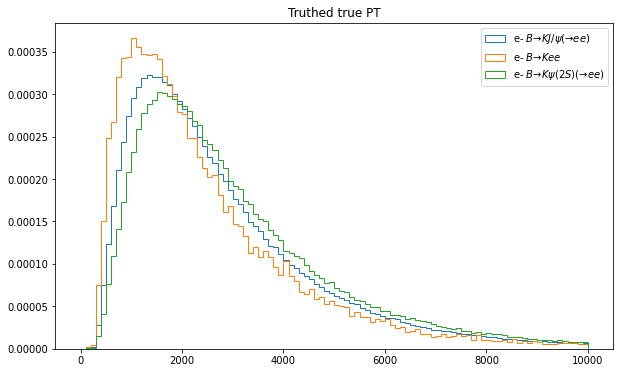

In [29]:
for idx in [0, 2, 4]:
    plt.hist(truthed[idx]['e_minus_TRUEPT'], label="e- %s"%df_index[idx],
             density=True, bins=np.linspace(0, 10000, 101), histtype='step')
plt.title('Truthed true PT')
plt.legend()
plt.show()

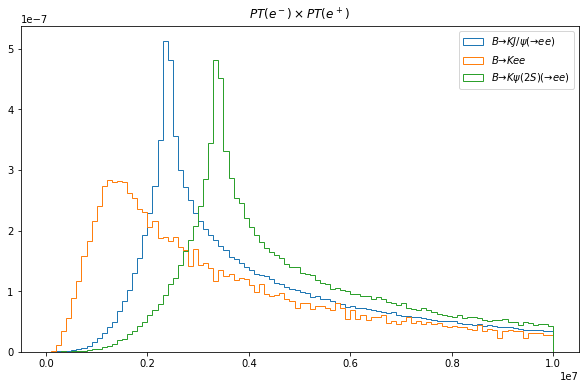

In [30]:
for idx in [0, 2, 4]:
    data = truthed[idx]
    plt.hist(data['e_minus_TRUEPT']*data['e_plus_TRUEPT'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(0, 10000000, 101), histtype='step')
plt.title(r'$PT(e^-) \times PT(e^+)$')
plt.legend()
plt.show()

### Preprocessing

In [31]:
def make_dataset(fnames, idx):
    x = list()
    y = list()
    for i, ix in enumerate(idx):
        x_ = np.hstack([truthed[ix][fn].reshape(-1, 1) for fn in fnames])
        y_ = np.repeat(i, x_.shape[0])
        x.append(x_)
        y.append(y_)
    X = np.vstack(x)
    Y = np.hstack(y)
    return X, Y

In [32]:
X, Y = make_dataset(['e_minus_TRUEPT', 'e_plus_TRUEPT'], [0,2,4])
X.shape, Y.shape

((961995, 2), (961995,))

In [33]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, shuffle=True, stratify=Y, test_size=0.1)

In [34]:
y_train.mean(), y_test.mean()

(0.5101380811855001, 0.5101351351351351)

In [35]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(x_train)

StandardScaler()

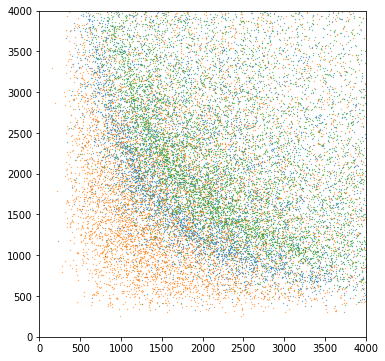

In [36]:
for label in [0,1,2]:
    idx = y_train==label
    x = x_train[idx][:10000]
    plt.scatter(*(x.T), marker=".", s=0.3)
plt.gca().set_aspect('equal')
plt.xlim(0,4000)
plt.ylim(0,4000)
plt.plot()
plt.show()

In [37]:
dataset = torch.utils.data.TensorDataset(
    torch.as_tensor(scaler.transform(x_train), dtype=torch.float, device=device),
    torch.as_tensor(y_train, dtype=torch.long, device=device)
)
loader = torch.utils.data.DataLoader(dataset, batch_size=10000)

In [38]:
counts = np.asarray([np.sum(y_train==label) for label in [0, 1, 2]])
counts

array([626915,  36085, 202795])

In [39]:
weights = y_train.shape[0]/counts/3
weights

array([0.46034683, 7.99773683, 1.42310379])

In [40]:
np_datasets = [make_dataset(['e_minus_TRUEPT', 'e_plus_TRUEPT'], [idx])[0] for idx in [0,2,4]]
datasets = [torch.utils.data.TensorDataset(
    torch.as_tensor(
        scaler.transform(np_ds),
        dtype=torch.float,
        device=device)
    ) for np_ds in np_datasets]

In [41]:
def get_random_samples(data, size=1000):
    index = torch.randint(len(data), size=(size,), device=device)
    return data[index]

### NN

In [42]:
def model():
    return nn.Sequential(
        nn.Linear(2, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 1),
    )

In [43]:
def train(model, epochs=20, sub_iter=1000, batch_size=1000):
    model.train()
    opt = torch.optim.Adam(params=model.parameters())
    for epoch in range(epochs):
        for i in range(sub_iter):
            loss = 0
            for label in [0, 1, 1, 2]:
                x, = get_random_samples(datasets[label], size=batch_size)
                y = torch.ones(batch_size, 1, dtype=torch.float, device=device)*(label==1)
                pred = model(x)
                loss += F.binary_cross_entropy_with_logits(input=pred, target=y)
            loss /= 4
            opt.zero_grad()
            loss.backward()
            opt.step()
        logging.info("Epoch %d, %f", epoch, loss)
    model.eval()

In [44]:
m = model().to(device)

In [45]:
train(m, epochs=50)

INFO:root:Epoch 0, 0.641588
INFO:root:Epoch 1, 0.638477
INFO:root:Epoch 2, 0.639422
INFO:root:Epoch 3, 0.629592
INFO:root:Epoch 4, 0.642371
INFO:root:Epoch 5, 0.627175
INFO:root:Epoch 6, 0.625700
INFO:root:Epoch 7, 0.622599
INFO:root:Epoch 8, 0.620013
INFO:root:Epoch 9, 0.619211
INFO:root:Epoch 10, 0.625672
INFO:root:Epoch 11, 0.627514
INFO:root:Epoch 12, 0.630106
INFO:root:Epoch 13, 0.627639
INFO:root:Epoch 14, 0.617807
INFO:root:Epoch 15, 0.627581
INFO:root:Epoch 16, 0.636353
INFO:root:Epoch 17, 0.621953
INFO:root:Epoch 18, 0.621045
INFO:root:Epoch 19, 0.618531
INFO:root:Epoch 20, 0.622562
INFO:root:Epoch 21, 0.620834
INFO:root:Epoch 22, 0.628261
INFO:root:Epoch 23, 0.633277
INFO:root:Epoch 24, 0.617189
INFO:root:Epoch 25, 0.623029
INFO:root:Epoch 26, 0.625825
INFO:root:Epoch 27, 0.617570
INFO:root:Epoch 28, 0.626425
INFO:root:Epoch 29, 0.628810
INFO:root:Epoch 30, 0.623552
INFO:root:Epoch 31, 0.625773
INFO:root:Epoch 32, 0.625475
INFO:root:Epoch 33, 0.626507
INFO:root:Epoch 34, 0.62

In [46]:
m.eval()

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=1, bias=True)
)

In [47]:
x = np.linspace(0, 6000, 1001).reshape(-1,1)
x_ = scaler.transform(np.hstack([x, x]))
y = m(torch.as_tensor(x_, dtype=torch.float, device=device)).detach().cpu().numpy()

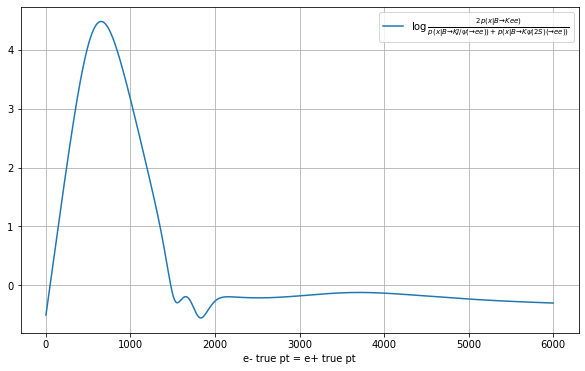

In [48]:
plt.plot(x, y, label=r'$\log\frac{2 p(x|B\to Kee)}{p(x|B\to KJ/\psi(\to ee))+p(x|B\to K\psi(2S)(\to ee))}$')
plt.grid()
plt.legend()
plt.xlabel('e- true pt = e+ true pt')
plt.show()

In [49]:
def plot_field(f, name=None):
    X_test = np.random.rand(30000, 2) * 6000
    y_pred = f(X_test).ravel()
    xi = np.linspace(0, 6000, 101)
    yi = np.linspace(0, 6000, 101)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=1.0, vmin=0.0)
    plt.colorbar()
    plt.xlim(0,6000)
    plt.ylim(0,6000)
    plt.gca().set_aspect('equal')
    if name is not None:
        plt.title(name)
    plt.show()

In [50]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def from_numpy(t):
    return torch.as_tensor(t, dtype=torch.float, device=device)
def plot_clf(clf):
    f = lambda x : to_numpy(torch.sigmoid(clf(from_numpy(scaler.transform(x)))))
    plot_field(f,
        r'$\sigma\left(\log\frac{2p(x|B\to Kee)}{p(x|B\to KJ/\psi(\to ee)+p(x|B\to K\psi(2S)(\to ee))}\right)$')

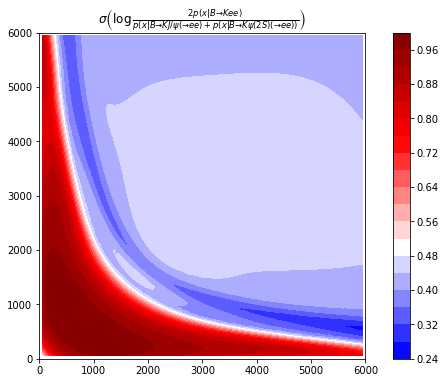

In [51]:
plot_clf(m)

### Pivoting

In [52]:
def adversary_model():
    return nn.Sequential(
        nn.Linear(1, 20),
        nn.Softplus(),
        nn.Linear(20, 20),
        nn.Softplus(),
        nn.Linear(20, 1),
    )

In [53]:
def adversary_train(clf, adv, epochs=20, sub_iter=30, adv_iter=20, batch_size=1000):
    opt_clf = torch.optim.Adam(params=clf.parameters(), lr=1e-3)
    opt_adv = torch.optim.Adamax(params=adv.parameters(), lr=5e-3)
    
    for epoch in range(epochs):
        for i_clf in range(sub_iter):
            clf.eval()
            adv.train()
            
            for i_adv in range(adv_iter):
                loss_adv = 0
                for label in [0, 2]:
                    x, = get_random_samples(datasets[label], size=batch_size)
                    with torch.no_grad():
                        pred = clf(x)
                    adv_pred = adv(pred)
                    adv_target = torch.ones(batch_size, 1, dtype=torch.float, device=device) * label/2
                    loss_adv += F.binary_cross_entropy_with_logits(
                        input=adv_pred, target=adv_target)/2
                opt_adv.zero_grad()
                loss_adv.backward()
                opt_adv.step()
                
            clf.train()
            adv.eval()

            loss_clf = 0
            loss_adv = 0
            for label in [0, 1, 1, 2]:
                x, = get_random_samples(datasets[label], size=batch_size)
                y = torch.ones(batch_size, 1, dtype=torch.float, device=device)*(label==1)
                pred = clf(x)
                loss_clf += F.binary_cross_entropy_with_logits(input=pred, target=y)/4
                if label != 1:
                    adv_pred = adv(pred)
                    adv_target = torch.ones(batch_size, 1, dtype=torch.float, device=device) * label/2
                    loss_adv += F.binary_cross_entropy_with_logits(
                        input=adv_pred, target=adv_target)/2
                    
            joint_loss = loss_clf - loss_adv
            opt_clf.zero_grad()
            joint_loss.backward()
            opt_clf.step()
                        
        logging.warning("Epoch %d, %f %f", epoch, loss_clf.item(), loss_adv.item())
    clf.eval()
    adv.eval()

In [54]:
clf = model().to(device)
wm = adversary_model().to(device)

In [55]:
clf.load_state_dict(m.state_dict())

<All keys matched successfully>

In [56]:
adversary_train(clf, wm, epochs=100)

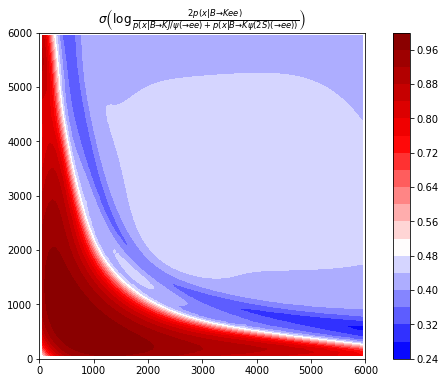

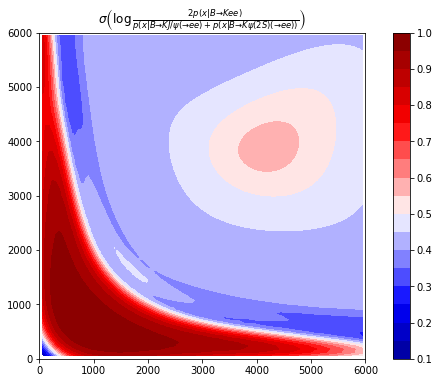

In [57]:
plot_clf(m)
plot_clf(clf)

In [58]:
@torch.no_grad()
def plot_adv(clf, adv):
    f = lambda x : to_numpy(torch.sigmoid(adv(clf(from_numpy(scaler.transform(x))))))
    plot_field(f, r'')

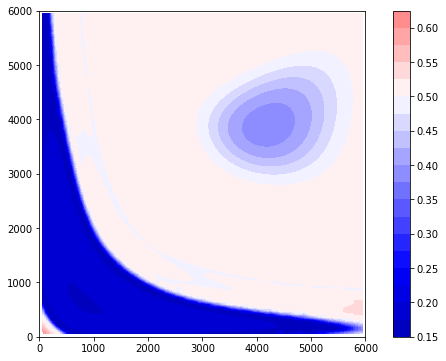

In [59]:
plot_adv(clf, wm)

### Checking

$$\begin{aligned}
\inf_x\frac{p_1(x)}{p_0(x)}
\leq
\frac{\mathbb{E}_{x\sim p_1}[w(x)]}{\mathbb{E}_{x\sim p_0}[w(x)]}
\leq
\sup_x\frac{p_1(x)}{p_0(x)}
.
\end{aligned}$$

In [60]:
wf = model().to(device)

In [61]:
def train_wf(clf, adv, model, epochs=20):
    model.train()
    clf.eval()
    adv.eval()
    opt = None
    for epoch in range(epochs):
        batch = None
        x, = batch
        with torch.no_grad():
            pred = clf(x)
            adv_pred = adv(pred)
        pass    
    model.eval()

In [62]:
@torch.no_grad()
def weighting_fn(arr):
    arr_ = from_numpy(scaler.transform(np.asarray(arr)))
    pred = to_numpy(wm(clf(arr_)))
    return np.exp(-pred**2)

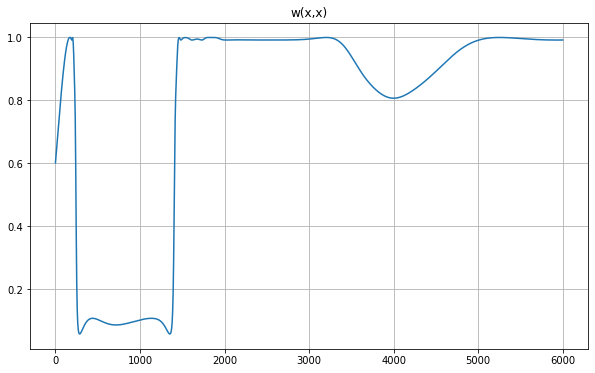

In [63]:
plt.plot(x, weighting_fn(np.hstack([x, x])))
plt.grid()
plt.title("w(x,x)")
plt.show()

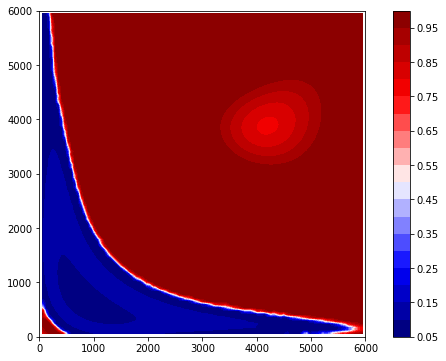

In [64]:
plot_field(weighting_fn)

In [65]:
w0 = weighting_fn(np_datasets[0])
w2 = weighting_fn(np_datasets[1])
w4 = weighting_fn(np_datasets[2])
df["w"] = [w0.mean(), 1, w2.mean(), 1, w4.mean(), 1]
df["wTruth"] = df["w"]*df["Truth"]
df

Total    Truth         w        wTruth
$B \to KJ/\psi(\to ee)$       2084124   696573  0.934367  6.508547e+05
$B \to KJ/\psi(\to\mu\mu)$    3206889  1459292  1.000000  1.459292e+06
$B \to Kee$                    413741    40094  0.747368  2.996499e+04
$B \to K\mu\mu$                665455    72469  1.000000  7.246900e+04
$B \to K\psi(2S)(\to ee)$      869415   225328  0.977503  2.202588e+05
$B \to K\psi(2S)(\to\mu\mu)$  2313029  1037738  1.000000  1.037738e+06

In [66]:
double_ratio(df["w"]), double_ratio_psi2S(df["w"])

(1.2502092511373333, 0.9558710543678024)

In [67]:
double_ratio(df["Truth"]), double_ratio(df["wTruth"])

(0.8627745334620901, 1.0786487033800018)

In [68]:
double_ratio_psi2S(df["Truth"]), double_ratio_psi2S(df["wTruth"])

(2.1983507867256966, 2.1013398843777797)

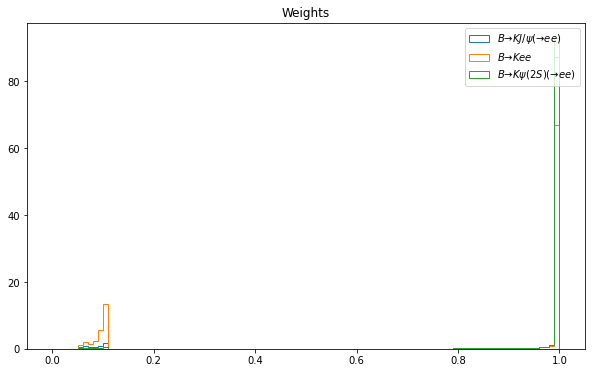

In [69]:
plt.hist(w0, label=df_index[0], density=True, bins=np.linspace(0, 1, 101), histtype='step', cumulative=False)
plt.hist(w2, label=df_index[2], density=True, bins=np.linspace(0, 1, 101), histtype='step', cumulative=False)
plt.hist(w4, label=df_index[4], density=True, bins=np.linspace(0, 1, 101), histtype='step', cumulative=False)
plt.title('Weights')
plt.legend()
plt.show()